**Data Analysis Interview Challenge**

Part 1 — Exploratory Data Analysis: User Login Patterns

In [1]:
import pandas as pd
import json

# Load JSON file
with open("logins.json", "r") as f:
    data = json.load(f)

# Convert to DataFrame
df_log = pd.DataFrame(data)

# Inspect the first few rows and keys
print("Columns:", df_log.columns)
df_log.head()

Columns: Index(['login_time'], dtype='object')


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [2]:
# Convert login_time to datetime
df_log['ts'] = pd.to_datetime(df_log['login_time'])

# Inspect
df_log.head()

,login_time,ts
0,1970-01-01 20:13:18,1970-01-01 20:13:18
1,1970-01-01 20:16:10,1970-01-01 20:16:10
2,1970-01-01 20:16:37,1970-01-01 20:16:37
3,1970-01-01 20:16:36,1970-01-01 20:16:36
4,1970-01-01 20:26:21,1970-01-01 20:26:21


In [3]:
# Aggregate by 15-minute intervals
df_agg = df_log.set_index('ts').resample('15min').size().reset_index(name='logins')

df_agg.head()

,ts,logins
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


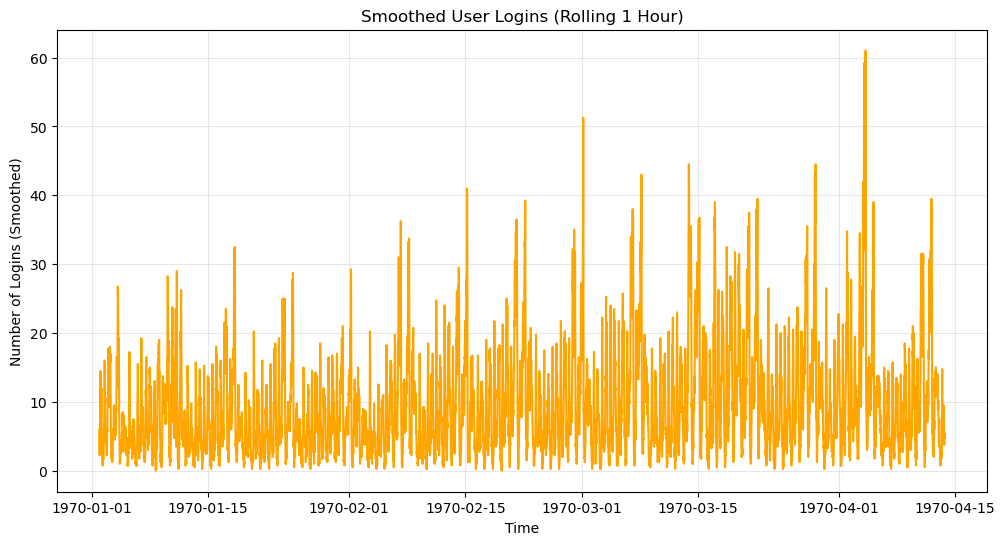

In [4]:
import matplotlib.pyplot as plt

# Rolling average (~1 hour)
df_agg['logins_smooth'] = df_agg['logins'].rolling(window=4).mean()

plt.figure(figsize=(12,6))
plt.plot(df_agg['ts'], df_agg['logins_smooth'], color='orange')
plt.xlabel('Time')
plt.ylabel('Number of Logins (Smoothed)')
plt.title('Smoothed User Logins (Rolling 1 Hour)')
plt.grid(alpha=0.3)
plt.show()

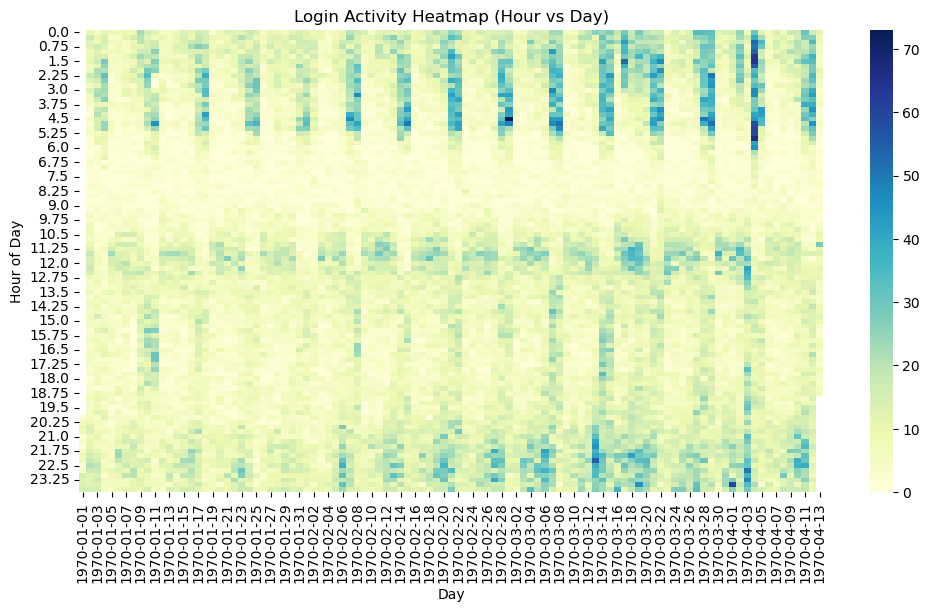

In [5]:
import seaborn as sns

# Extract day and hour
df_agg['day'] = df_agg['ts'].dt.date
df_agg['hour'] = df_agg['ts'].dt.hour + df_agg['ts'].dt.minute/60

# Pivot for heatmap
heatmap_data = df_agg.pivot_table(index='hour', columns='day', values='logins', aggfunc='sum')

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.xlabel('Day')
plt.ylabel('Hour of Day')
plt.title('Login Activity Heatmap (Hour vs Day)')
plt.show()

In [6]:
# Check for missing values
print("Missing timestamps:", df_log['ts'].isna().sum())

# Check for duplicates
print("Duplicate rows:", df_log.duplicated().sum())

# Check for negative or zero logins after aggregation
print("Intervals with zero logins:", (df_agg['logins']==0).sum())

Missing timestamps: 0
Duplicate rows: 877
Intervals with zero logins: 407


**summary of EDA**

- Daily cycles: Heatmap shows peak login hours clearly and off-peak periods.
- Trends: Smoothed line captures general login trends without noise.
- Data quality: No missing timestamps or duplicates; zero-login intervals correspond to off-peak hours.

This dataset is now ready for further analysis or modeling.

Part 2 - Experiment and Metrics Design

## Objective
Test whether reimbursing toll costs increases the number of driver partners serving both Gotham and Metropolis.

## Key Measure of Success
**Primary metric:** Proportion of drivers serving both cities during the experiment.  
**Rationale:** Directly measures the impact of toll reimbursement on multi-city participation.  
**Secondary metric (optional):** Number of cross-city trips to capture activity intensity.

## Experiment Design
- **Method:** Randomized A/B test  
- **Population:** Active drivers in Gotham and Metropolis  
- **Treatment group:** Toll reimbursement offered  
- **Control group:** No reimbursement  
- **Duration:** Several weeks (includes weekday and weekend behavior)  
- **Measurement:** Track drivers serving both cities

## Statistical Analysis
- **Primary test:** Chi-square test comparing the proportion of multi-city drivers  
  - H₀: Toll reimbursement has no effect  
  - H₁: Toll reimbursement increases multi-city participation  
- **Secondary analysis:** t-test or Mann–Whitney U test for cross-city trip counts

## Interpretation & Recommendations
- **Significant increase:** Toll reimbursement is effective; consider rollout if cost-effective.  
- **No significant difference:** Additional or alternative incentives may be needed.

## Caveats
- Results may be influenced by external factors (e.g., seasonality).  
- Repeat the experiment to confirm consistency.  
- Ensure proper randomization to avoid bias.


Part 3 — Predictive Modeling: Rider Retention

In [7]:
import pandas as pd
import json

# Load JSON
with open("ultimate_data_challenge.json", "r") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Inspect first few rows and columns
print("Columns:", df.columns)
df.head()

Columns: Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [8]:
# Convert date columns
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Define retention: active within 30 days of dataset end 
observation_end = pd.to_datetime("2014-06-30")
df['retained'] = (df['last_trip_date'] >= observation_end - pd.Timedelta(days=30)).astype(int)

# Inspect
df[['signup_date','last_trip_date','retained']].head()

,signup_date,last_trip_date,retained
0,2014-01-25,2014-06-17,1
1,2014-01-29,2014-05-05,0
2,2014-01-06,2014-01-07,0
3,2014-01-10,2014-06-29,1
4,2014-01-27,2014-03-15,0


Retention rate: 38.45%


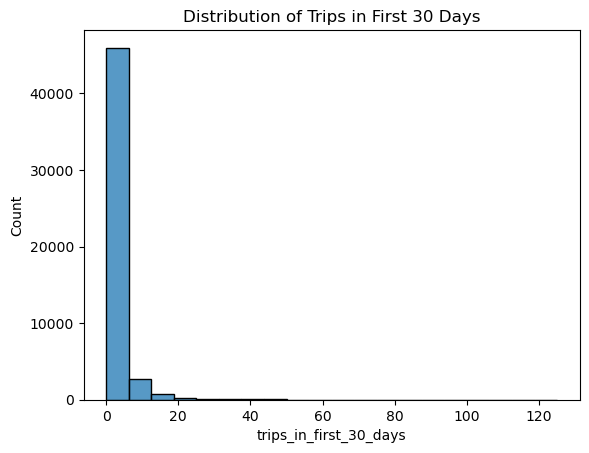

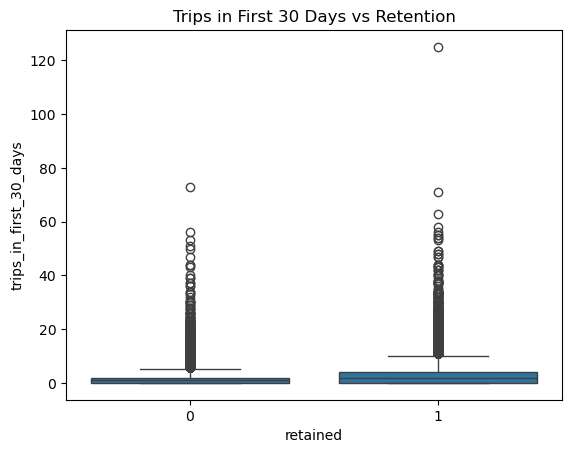

In [9]:
# Fraction of retained users
retention_rate = df['retained'].mean()
print(f"Retention rate: {retention_rate:.2%}")

# Summary statistics
df.describe()

# Optional: visualize key features
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['trips_in_first_30_days'], bins=20, kde=False)
plt.title("Distribution of Trips in First 30 Days")
plt.show()

sns.boxplot(x='retained', y='trips_in_first_30_days', data=df)
plt.title("Trips in First 30 Days vs Retention")
plt.show()

In [10]:
# One-hot encode categorical variables
df_model = pd.get_dummies(df, columns=['city','phone'], drop_first=True)

# Select features and target
features = ['trips_in_first_30_days', 'avg_dist', 'avg_rating_by_driver', 
            'avg_rating_of_driver', 'surge_pct', 'avg_surge', 'ultimate_black_user', 'weekday_pct'] + \
           [col for col in df_model.columns if 'city_' in col or 'phone_' in col]

X = df_model[features]
y = df_model['retained']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

Accuracy: 0.708
ROC AUC: 0.754557186002267
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      6155
           1       0.66      0.49      0.56      3845

    accuracy                           0.71     10000
   macro avg       0.69      0.67      0.67     10000
weighted avg       0.70      0.71      0.70     10000



In [14]:
coefficients = pd.Series(model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
coefficients.head(10)

city_King's Landing       1.687369
phone_iPhone              1.029191
ultimate_black_user       0.856615
city_Winterfell           0.499438
avg_surge                -0.194824
avg_rating_by_driver     -0.136552
avg_rating_of_driver     -0.135948
trips_in_first_30_days    0.115573
avg_dist                 -0.037533
surge_pct                 0.003695
dtype: float64

## Recommendations
- Drive early engagement: First 30-day trip volume predicts retention.
- Focus on high-value users: Ultimate Black and high-rating riders are more loyal.
- Re-engage low-activity users: Use nudges or promotions.
- Iterate continuously: Update and monitor the model with new data.
